In [11]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Helper function for visualizing the segmentation masks. 
def showMask(mask, ylabel=None, showCoM=None):
    sz = mask.shape
    if showCoM is not None:
        [xs, ys, zs] = np.nonzero(mask)
        x = np.round(np.mean(xs)).astype('int')
        y = np.round(np.mean(ys)).astype('int')
        z = np.round(np.mean(zs)).astype('int')
        d = 10
        cop = mask.copy()
        mask = cop
        mask[(x-d):(x+d), (y-d):(y+d), (z-d):(z+d)] = 1
    if True: # Mask is collapsed along the three scan axes
        fig, (ax0,ax1,ax2) = plt.subplots(1,3)
        ax0.imshow(np.sum(mask,axis=0))
        ax1.imshow(np.sum(mask,axis=1))
        ax2.imshow(np.sum(mask,axis=2))   
    else: # Also the center slice is shown for each axis
        fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,6)
        ax0.imshow(mask[sz[0]//2,:,:])
        ax1.imshow(np.sum(mask,axis=0))
        ax2.imshow(mask[:,sz[1]//2,:])
        ax3.imshow(np.sum(mask,axis=1))
        ax4.imshow(mask[:,:,sz[2]//2])
        ax5.imshow(np.sum(mask,axis=2))
    if ylabel is not None:
        ax0.set_ylabel(ylabel)

In [13]:
def dilation(mask):
    dialated = np.zeros(mask.shape)

    idx = np.argwhere(mask==1)
    #dialated[idx]=2
    for n in idx:
        i = n[0]
        j = n[1]
        k = n[2]
        
        if i+1 > mask.shape[0] or i==0:
            continue
        if j+1 > mask.shape[1] or j ==0:
            continue
        if k+1 > mask.shape[2] or k ==0:
            continue

        if mask[i+1,j,k]==1 and mask[i,j+1,k]==1 and mask[i,j,k+1]==1 and mask[i-1,j,k]==1 and mask[i,j-1,k]==1 and mask[i,j,k-1]==1:
            dialated[i,j,k] = 1
                    
    return dialated

#showMask(dilation(mask_fem))

In [14]:
def erosion(mask):
    ero = np.zeros(mask.shape)

    idx = np.argwhere(mask==1)
    for n in idx:
        i = n[0]
        j = n[1]
        k = n[2]
        
        if i+1 >= mask.shape[0]-1 or i==0:
            continue
        if j+1 >= mask.shape[1]-1 or j ==0:
            continue
        if k+1 >= mask.shape[2]-1 or k ==0:
            continue
        
        if mask[i,j,k] == 1: 
                ero[i,j,k] = 1

                ero[i-1,j,k] = 1
                ero[i,j+1,k] = 1
                ero[i,j,k+1] = 1

                ero[i+1,j,k] = 1
                ero[i,j+1,k] = 1
                ero[i,j,k+1] = 1

    return ero

#showMask(erosion(mask_fem))

Now retrieve features

In [15]:
df_mri = pd.read_csv("mri_data_shape", index_col ="Unnamed: 0")
directory = 'OsteoarthritisInitiative/my_predictions/nii_files/'

In [28]:
a = 0

for idx in df_mri.index:
    a +=1
    
    if df_mri["Closing Meniscus"].loc[idx] != 0.0:
        continue

    path = directory+"/"+idx+"_PRED.nii.gz"
    seg = nib.load(path).get_fdata()
    n = seg.shape[0]*seg.shape[1]*seg.shape[2]
    
    mask_fem = np.where(seg==1,1,0)
    mask_tib = np.where(seg==2,1,0)
    mask_min = np.where(seg==4,1,0)
    
    open_fem = dilation(dilation(erosion(erosion(mask_fem))))
    close_fem = erosion(erosion(dilation(dilation(mask_fem))))

    df_mri.loc[idx, ("Opening Femur")] =  ((mask_tib - open_fem)**2).sum()
    df_mri.loc[idx, ("Closing Femur")] =  ((mask_tib - close_fem)**2).sum()

    
    open_tib = dilation(dilation(erosion(erosion(mask_tib))))
    close_tib = erosion(erosion(dilation(dilation(mask_tib))))

    df_mri.loc[idx, ("Opening Tibial")] =  ((mask_tib - open_tib)**2).sum()
    df_mri.loc[idx, ("Closing Tibial")] =  ((mask_tib - close_tib)**2).sum()

    
    open_min = dilation(dilation(erosion(erosion(mask_min))))
    close_min = erosion(erosion(dilation(dilation(mask_min))))

    df_mri.loc[idx, ("Opening Meniscus")] =  ((mask_min - open_min)**2).sum()
    df_mri.loc[idx, ("Closing Meniscus")] =  ((mask_min - close_min)**2).sum()

    #print("Done: ", idx)

    if a/5 == a//5:
        print(a)
        df_mri.to_csv("mri_data_shape")

df_mri.to_csv("mri_data_shape")

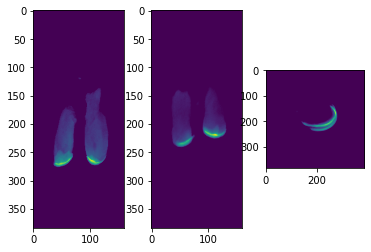

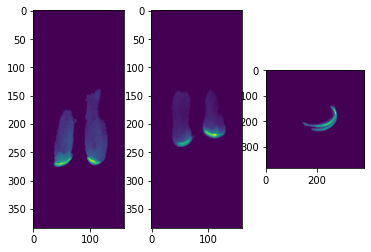

In [29]:
showMask(dilation(dilation(erosion(erosion(mask_fem)))))
showMask(erosion(erosion(dilation(dilation(mask_fem)))))

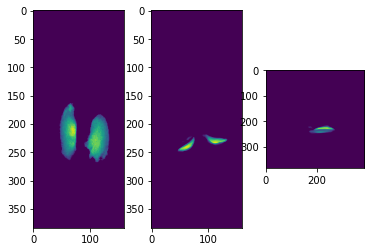

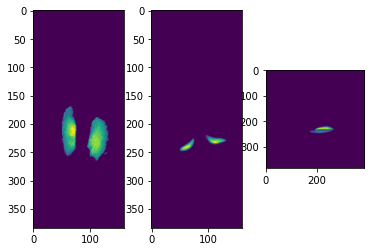

In [30]:
showMask(dilation(dilation(erosion(erosion(mask_tib)))))
showMask(erosion(erosion(dilation(dilation(mask_tib)))))

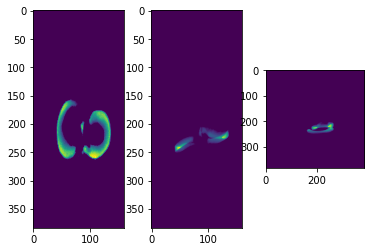

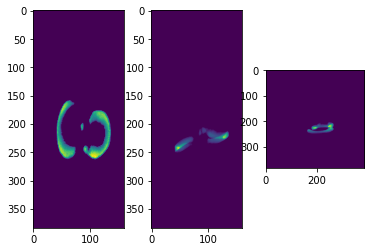

In [31]:
showMask(dilation(dilation(erosion(erosion(mask_min)))))
showMask(erosion(erosion(dilation(dilation(mask_min)))))

In [32]:
df_mri.loc["9986207-Left-V00"]

Opening Femur       101027
Closing Femur        96408
Opening Tibial        1471
Closing Tibial        5344
Opening Meniscus      3632
Closing Meniscus      5641
Name: 9986207-Left-V00, dtype: int64